## Ingest images
Images of each deer are roughly square, and stored in a local folder. The images are ingested via `glob` and files that do not contain year information is removed. Once ingested, resized, and stacked, the labels are extracted from each images based on their filename.

In [1]:
from glob import glob
from generic.analysis.basics import extract_labels
from generic.analysis.basics import ingest_resize_stack

# Find/ingest files in folder; force square & b/w
files = glob("..\\images\\squared\\*.png")
files = [s for s in files if "xpx" not in s]
print(len(files), "images found")

# Ingest images
images = ingest_resize_stack(files)
_,_,_,ages,_ = extract_labels(files)
print('Sample size:', images.shape)

77 images found
Sample size: (77, 288, 288)


## Split datasets
The image stack is then split into training and test data, with a split of 80/20 -- 80% of the data resides in the training set, while the remaining 20% defines the test data. The training and test data are then normalized, and the labels for each dataset are cast to categorical values instead of their age values.

The validation data is then extracted from the training dataset, again in an 80/20 split -- 80% of the previous training data remains within the training dataset, and 20% is redefined as the validation set. Each dataset (training, validation, and test) are reshaped based on their format of grayscale images.

In [2]:
import keras
import numpy as np
from sklearn.model_selection import train_test_split

# Create a mapping that combines 5.5+ years into a single "mature" class
ages_array = np.array(ages)
mature_ages = []

for i, age in enumerate(ages_array):
    if age >= 5.5:
        ages_array[i] = 5.5  # Set all ages 5.5+ to 5.5
        if age not in mature_ages:
            mature_ages.append(age)

print(f"Merged these ages into the 'mature' (5.5+) class: {mature_ages}")

# Now create your label mapping with the modified ages
label_mapping = {label: i for i, label in enumerate(np.unique(ages_array))}
print("New label mapping:", label_mapping)

# Apply the mapping to convert labels to integers
integer_labels = np.array([label_mapping[l] for l in ages_array])

# Implement a stratified split to ensure all classes appear in train and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    images, integer_labels, 
    test_size=0.2, 
    random_state=42,
    stratify=integer_labels  # This ensures proportional representation of classes
)

# Check the class distribution in training+validation set
print("\nClass distribution after first split:")
for label in np.unique(y_train_val):
    count = np.sum(y_train_val == label)
    print(f"Label {label} ({list(label_mapping.keys())[list(label_mapping.values()).index(label)]}): {count} samples")

# One-hot encode labels AFTER splitting but BEFORE the next split
num_classes = len(label_mapping)
y_train_val_onehot = keras.utils.to_categorical(y_train_val, num_classes)
y_test_onehot = keras.utils.to_categorical(y_test, num_classes)

# Normalize and reshape images
X_train_val = X_train_val.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0
X_train_val = X_train_val.reshape(X_train_val.shape[0], 288, 288, 1)
X_test = X_test.reshape(X_test.shape[0], 288, 288, 1)

# Implement stratified split for validation too
X_train_orig, X_valid, y_train_orig, y_valid = train_test_split(
    X_train_val, 
    y_train_val_onehot, 
    test_size=0.2, 
    random_state=42,
    stratify=np.argmax(y_train_val_onehot, axis=1)  # Stratify by class
)

# Print the class distribution to check
print("\nTraining set class distribution (after both splits):")
train_class_dist = np.argmax(y_train_orig, axis=1)
for label in np.unique(train_class_dist):
    count = np.sum(train_class_dist == label)
    print(f"Label {label} ({list(label_mapping.keys())[list(label_mapping.values()).index(label)]}): {count} samples")

print("\nValidation set class distribution:")
valid_class_dist = np.argmax(y_valid, axis=1)
for label in np.unique(valid_class_dist):
    count = np.sum(valid_class_dist == label)
    print(f"Label {label} ({list(label_mapping.keys())[list(label_mapping.values()).index(label)]}): {count} samples")

Merged these ages into the 'mature' (5.5+) class: [np.float64(5.5), np.float64(12.5), np.float64(6.5), np.float64(7.5)]
New label mapping: {np.float64(1.5): 0, np.float64(2.5): 1, np.float64(3.5): 2, np.float64(4.5): 3, np.float64(5.5): 4}

Class distribution after first split:
Label 0 (1.5): 11 samples
Label 1 (2.5): 15 samples
Label 2 (3.5): 14 samples
Label 3 (4.5): 7 samples
Label 4 (5.5): 14 samples

Training set class distribution (after both splits):
Label 0 (1.5): 9 samples
Label 1 (2.5): 12 samples
Label 2 (3.5): 11 samples
Label 3 (4.5): 5 samples
Label 4 (5.5): 11 samples

Validation set class distribution:
Label 0 (1.5): 2 samples
Label 1 (2.5): 3 samples
Label 2 (3.5): 3 samples
Label 3 (4.5): 2 samples
Label 4 (5.5): 3 samples


In [3]:
# After your initial train/test split, you should have X_train_val, X_test, y_train_val, y_test
# X_train_val and y_train_val are what you want to use instead of X_train and y_train

# Get the number of classes
num_classes = len(label_mapping)

# One-hot encode labels BEFORE splitting into train/validation
y_train_val_onehot = keras.utils.to_categorical(y_train_val, num_classes)
y_test_onehot = keras.utils.to_categorical(y_test, num_classes)

# Reshape data to add channel dimension
X_train_val = X_train_val.reshape(X_train_val.shape[0], 288, 288, 1)
X_test = X_test.reshape(X_test.shape[0], 288, 288, 1)

# Create a validation set (without stratification)
X_train_orig, X_valid, y_train_orig, y_valid = train_test_split(
    X_train_val, 
    y_train_val_onehot, 
    test_size=0.2, 
    random_state=42
)

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Print original sizes
print("\nBefore augmentation:")
print(X_train_orig.shape[0], "train samples")
print(X_test.shape[0], "test samples")
print(X_valid.shape[0], "validation samples")

# Setup moderate data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,              
    width_shift_range=0.2,          
    height_shift_range=0.2,
    zoom_range=0.2,                 
    horizontal_flip=True,           
    brightness_range=[0.7, 1.3],    
    shear_range=10,                
    fill_mode='nearest'
)

# Create augmented images per class to balance the dataset
augmented_images = []
augmented_labels = []

# Find the count of the majority class
unique_classes = np.unique(np.argmax(y_train_orig, axis=1))
class_counts = [np.sum(np.argmax(y_train_orig, axis=1) == c) for c in unique_classes]
max_count = max(class_counts)
target_per_class = max_count * 2  # Increase all classes to 2x the size of the largest class

# Augment each class separately
for class_idx in unique_classes:
    # Get indices of samples from this class
    class_indices = np.where(np.argmax(y_train_orig, axis=1) == class_idx)[0]
    class_count = len(class_indices)
    
    # Calculate how many augmented samples to generate
    samples_to_generate = target_per_class - class_count
    
    if samples_to_generate <= 0:
        continue  # Skip if we already have enough
    
    # Get the class samples
    class_images = X_train_orig[class_indices]
    class_labels = y_train_orig[class_indices]
    
    # Generate augmented samples
    aug_gen = datagen.flow(
        class_images,
        class_labels,
        batch_size=class_count,
        shuffle=True
    )
    
    # Generate the required number of samples
    batch_count = int(np.ceil(samples_to_generate / class_count))
    aug_img_list = []
    aug_label_list = []
    
    for i in range(batch_count):
        imgs, lbls = next(aug_gen)
        aug_img_list.append(imgs)
        aug_label_list.append(lbls)
    
    # Concatenate all batches and trim excess
    aug_images = np.concatenate(aug_img_list)[:samples_to_generate]
    aug_labels = np.concatenate(aug_label_list)[:samples_to_generate]
    
    # Add to our collections
    augmented_images.append(aug_images)
    augmented_labels.append(aug_labels)

# Combine all augmented data
if augmented_images:  # Check if we actually generated any augmentations
    X_aug = np.concatenate(augmented_images)
    y_aug = np.concatenate(augmented_labels)
    
    # Combine with original data
    X_train_combined = np.concatenate([X_train_orig, X_aug])
    y_train_combined = np.concatenate([y_train_orig, y_aug])
else:
    X_train_combined = X_train_orig
    y_train_combined = y_train_orig

# Print new sizes after augmentation
print("\nAfter class-balanced augmentation:")
print("Original training samples:", X_train_orig.shape[0])
print("Augmented training samples:", X_train_combined.shape[0] - X_train_orig.shape[0])
print("Combined training samples:", X_train_combined.shape[0])
print("Augmentation multiplier:", X_train_combined.shape[0] / X_train_orig.shape[0])
print("X_train_combined shape:", X_train_combined.shape)
print("y_train_combined shape:", y_train_combined.shape)

# Check class distribution after augmentation
print("\nClass distribution after augmentation:")
aug_class_dist = np.argmax(y_train_combined, axis=1)
for label in unique_classes:
    count = np.sum(aug_class_dist == label)
    print(f"Label {label} ({list(label_mapping.keys())[list(label_mapping.values()).index(label)]}): {count} samples")


Before augmentation:
48 train samples
16 test samples
13 validation samples

After class-balanced augmentation:
Original training samples: 48
Augmented training samples: 72
Combined training samples: 120
Augmentation multiplier: 2.5
X_train_combined shape: (120, 288, 288, 1)
y_train_combined shape: (120, 5)

Class distribution after augmentation:
Label 0 (1.5): 24 samples
Label 1 (2.5): 24 samples
Label 2 (3.5): 24 samples
Label 3 (4.5): 24 samples
Label 4 (5.5): 24 samples


## Build network
With the data formatted and separated, we can now build the CNN.

In [5]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.regularizers import l2
from keras.optimizers import Adam

# Create a simpler model that's less likely to overfit
model = Sequential()

# First convolutional block - keep it simple
model.add(Conv2D(8, kernel_size=3, padding='same', activation='relu', input_shape=(288, 288, 1)))
model.add(MaxPooling2D(pool_size=2))

# Second convolutional block
model.add(Conv2D(16, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

# Third convolutional block
model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

# Global pooling to reduce parameters
model.add(GlobalAveragePooling2D())

# Classification head - minimal dense layers
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))  # Moderate dropout
model.add(Dense(num_classes, activation='softmax'))

model.summary()

# Use a much lower learning rate - crucial for small datasets
model.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.00005),  # Very low learning rate
    metrics=['accuracy']
)

G:\Dropbox\AI Projects\buck\buck-env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 288, 288, 8)         │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 144, 144, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 144, 144, 16)        │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 72, 72, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,109 (27.77 KB)

 Trainable params: 7,109 (27.77 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights properly based on the raw class distribution
# Extract the class labels from one-hot encoded y_train_orig
y_integers = np.argmax(y_train_combined, axis=1)

# Compute balanced class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_integers),
    y=y_integers
)

# Convert to dictionary format for Keras
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Class weights:", class_weight_dict)

# Set up improved callbacks
checkpointer = ModelCheckpoint(
    filepath='model_improved.weights.best.hdf5.keras',
    verbose=1, 
    save_best_only=True,
    monitor='val_accuracy'  # Changed to monitor accuracy instead of loss
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=20,  # Give it more time to learn
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

print("\nTraining with improved configuration:")
hist_improved = model.fit(
    X_train_combined, 
    y_train_combined,
    batch_size=8,  # Smaller batch size for better learning with small dataset
    epochs=100,
    validation_data=(X_valid, y_valid),
    callbacks=[checkpointer, early_stopping, reduce_lr],
    verbose=1,
    shuffle=True,
    class_weight=class_weight_dict
)

Class weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0), 3: np.float64(1.0), 4: np.float64(1.0)}

Training with improved configuration:
Epoch 1/100
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1762 - loss: 1.6094
Epoch 1: val_accuracy improved from -inf to 0.23077, saving model to model_improved.weights.best.hdf5.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.1720 - loss: 1.6095 - val_accuracy: 0.2308 - val_loss: 1.6093 - learning_rate: 5.0000e-05
Epoch 2/100
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2681 - loss: 1.6094
Epoch 2: val_accuracy improved from 0.23077 to 0.30769, saving model to model_improved.weights.best.hdf5.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2610 - loss: 1.6094 - val_accuracy: 0.3077 - val_loss: 1.6093 - learning_rate: 5.0000e-05
Epoch 3/100
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1821 - loss: 1.6094
Epoch 3: val_accuracy did not improve from 0.30769
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s

In [7]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights using a more aggressive approach for small datasets
y_integers = np.argmax(y_train_combined, axis=1)

# Count samples per class
unique_classes, class_counts = np.unique(y_integers, return_counts=True)
count_dict = dict(zip(unique_classes, class_counts))

# Custom class weight calculation - more aggressive than sklearn's balanced approach
max_count = max(class_counts)
class_weight_dict = {cls: max_count / count for cls, count in count_dict.items()}

# Optional: Make weights even more extreme to force the model to learn minority classes
for cls in class_weight_dict:
    if class_weight_dict[cls] > 1:
        class_weight_dict[cls] *= 1.5  # Boost minority classes even more

print("Custom class weights:", class_weight_dict)

# Set up improved callbacks
checkpointer = ModelCheckpoint(
    filepath='model_improved.weights.best.hdf5.keras',
    verbose=1, 
    save_best_only=True,
    monitor='val_accuracy'
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=30,  # More patience for a small dataset
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,  # Larger reduction
    patience=10,
    min_lr=0.000001,
    verbose=1
)

print("\nTraining with custom class weights:")
hist_improved = model.fit(
    X_train_combined, 
    y_train_combined,
    batch_size=4,  # Very small batch size to help with class imbalance
    epochs=150,    # More epochs since we have early stopping
    validation_data=(X_valid, y_valid),
    callbacks=[checkpointer, early_stopping, reduce_lr],
    verbose=1,
    shuffle=True,
    class_weight=class_weight_dict
)

Custom class weights: {np.int64(0): np.float64(1.0), np.int64(1): np.float64(1.0), np.int64(2): np.float64(1.0), np.int64(3): np.float64(1.0), np.int64(4): np.float64(1.0)}

Training with custom class weights:
Epoch 1/150
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2055 - loss: 1.6094
Epoch 1: val_accuracy improved from -inf to 0.15385, saving model to model_improved.weights.best.hdf5.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.2046 - loss: 1.6094 - val_accuracy: 0.1538 - val_loss: 1.6093 - learning_rate: 1.2500e-05
Epoch 2/150
26/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2497 - loss: 1.6094
Epoch 2: val_accuracy improved from 0.15385 to 0.30769, saving model to model_improved.weights.best.hdf5.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2453 - loss: 1.6094 - val_accuracy: 0.3077 - val_loss: 1.6093 - learning_rate: 1.2500e-05
Epoch 3/150
26/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2789 - loss: 1.6094
Epoch 3: val_accuracy did

In [9]:
# Create an ensemble of models to improve performance
print("\nTraining an ensemble of models for better performance")

# First, define y_true from the test set for evaluation
y_true = np.argmax(y_test_onehot, axis=1)

# Import confusion matrix
from sklearn.metrics import confusion_matrix

# Number of models in our ensemble
num_models = 3
ensemble_models = []

for i in range(num_models):
    print(f"\nTraining model {i+1}/{num_models}")
    
    # Create a model with slightly different architecture
    model_i = Sequential()
    model_i.add(Conv2D(8, kernel_size=3+i, padding='same', activation='relu', input_shape=(288, 288, 1)))
    model_i.add(MaxPooling2D(pool_size=2))
    model_i.add(Conv2D(16, kernel_size=3, padding='same', activation='relu'))
    model_i.add(MaxPooling2D(pool_size=2))
    model_i.add(Conv2D(32, kernel_size=3, padding='same', activation='relu'))
    model_i.add(MaxPooling2D(pool_size=2))
    model_i.add(GlobalAveragePooling2D())
    model_i.add(Dense(32, activation='relu'))
    model_i.add(Dropout(0.3))
    model_i.add(Dense(num_classes, activation='softmax'))
    
    # Compile with slightly different learning rate
    model_i.compile(
        loss='categorical_crossentropy', 
        optimizer=Adam(learning_rate=0.00005 * (1 + i*0.5)),
        metrics=['accuracy']
    )
    
    # Train with slightly different hyperparameters
    model_i.fit(
        X_train_combined, 
        y_train_combined,
        batch_size=4+i*2,
        epochs=100,
        validation_data=(X_valid, y_valid),
        callbacks=[early_stopping, reduce_lr],
        verbose=1,
        shuffle=True,
        class_weight=class_weight_dict
    )
    
    ensemble_models.append(model_i)

# Make ensemble predictions on test set
ensemble_preds = []
for model_i in ensemble_models:
    pred_i = model_i.predict(X_test, verbose=0)
    ensemble_preds.append(pred_i)

# Average predictions from all models
ensemble_pred_prob = sum(ensemble_preds) / len(ensemble_preds)
ensemble_pred = np.argmax(ensemble_pred_prob, axis=1)

# Evaluate ensemble performance
ensemble_accuracy = np.mean(ensemble_pred == y_true)
print(f"\nEnsemble Test Accuracy: {ensemble_accuracy:.4f}")

# Check if ensemble makes diverse predictions
unique_predictions = set(ensemble_pred)
print(f"Ensemble predicts {len(unique_predictions)} different classes: {unique_predictions}")


Training an ensemble of models for better performance

Training model 1/3
Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.1705 - loss: 1.6095 - val_accuracy: 0.2308 - val_loss: 1.6094 - learning_rate: 5.0000e-05
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.2637 - loss: 1.6094 - val_accuracy: 0.2308 - val_loss: 1.6094 - learning_rate: 5.0000e-05
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.1925 - loss: 1.6095 - val_accuracy: 0.2308 - val_loss: 1.6094 - learning_rate: 5.0000e-05
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2604 - loss: 1.6094 - val_accuracy: 0.2308 - val_loss: 1.6095 - learning_rate: 5.0000e-05
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.1977 - loss: 1.6094 - val_accuracy: 0.2308 - val_loss: 1.6095 - learning_rate: 5.0000e-05
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1980 - loss: 1.6094 - val_accuracy: 0.1538 - val_loss: 1.6095 - learning_rate: 

NameError: name 'confusion_matrix' is not defined


Trying traditional machine learning approaches better suited for very small datasets
Reduced dimensions from 82944 to 20

Decision Tree Accuracy: 0.1875
Decision Tree predicts 3 different classes: {np.int64(2), np.int64(3), np.int64(4)}

Random Forest Accuracy: 0.2500
Random Forest predicts 4 different classes: {np.int64(1), np.int64(2), np.int64(3), np.int64(4)}

Gradient Boosting Accuracy: 0.1250
Gradient Boosting predicts 5 different classes: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)}

Logistic Regression Accuracy: 0.1250
Logistic Regression predicts 5 different classes: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)}

Best model is Random Forest with accuracy 0.2500


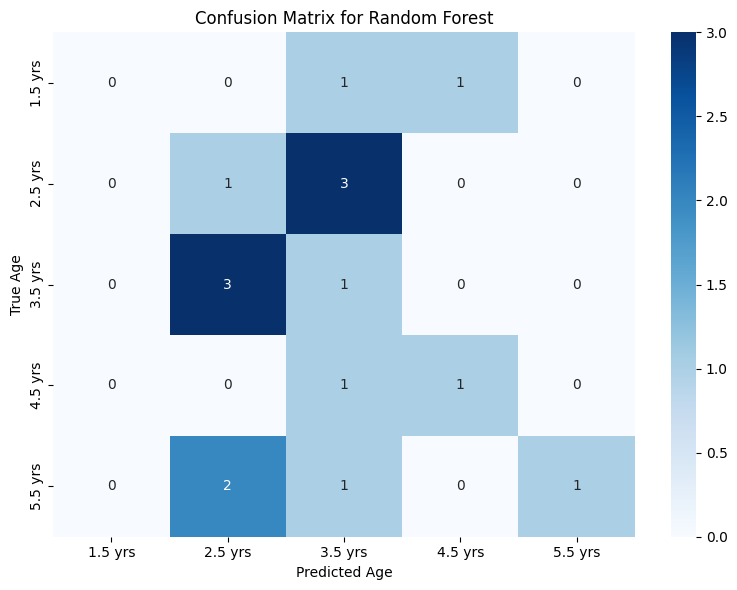


Classification Report for Best Model:
              precision    recall  f1-score   support

     Age 1.5       0.00      0.00      0.00         2
     Age 2.5       0.17      0.25      0.20         4
     Age 3.5       0.14      0.25      0.18         4
     Age 4.5       0.50      0.50      0.50         2
     Age 5.5       1.00      0.25      0.40         4

    accuracy                           0.25        16
   macro avg       0.36      0.25      0.26        16
weighted avg       0.39      0.25      0.26        16


Trying a voting classifier to combine all models
Voting Classifier Accuracy: 0.1875
Voting Classifier predicts 5 different classes: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)}

Predictions for each test sample:

Sample 1 - True age: 4.5 years
  Decision Tree: 4.5 years ✓
  Random Forest: 4.5 years ✓
  Gradient Boosting: 2.5 years ✗
  Logistic Regression: 4.5 years ✓

Sample 2 - True age: 1.5 years
  Decision Tree: 4.5 years ✗
  Random Forest: 4.

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

print("\nTrying traditional machine learning approaches better suited for very small datasets")

# Import necessary libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Create reverse mapping to get original labels
reverse_mapping = {i: label for label, i in label_mapping.items()}

# Flatten the images for use with simpler models
X_train_flat = X_train_combined.reshape(X_train_combined.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
y_train_flat = np.argmax(y_train_combined, axis=1)
y_true = np.argmax(y_test_onehot, axis=1)

# Apply dimensionality reduction - critical for such high-dimensional data with few samples
pca = PCA(n_components=min(20, X_train_flat.shape[0] - 5))  # Fewer components than samples
X_train_pca = pca.fit_transform(StandardScaler().fit_transform(X_train_flat))
X_test_pca = pca.transform(StandardScaler().fit_transform(X_test_flat))

print(f"Reduced dimensions from {X_train_flat.shape[1]} to {X_train_pca.shape[1]}")

# 1. Decision Tree with limited depth to avoid overfitting
tree_model = DecisionTreeClassifier(max_depth=3, class_weight='balanced', random_state=42)
tree_model.fit(X_train_pca, y_train_flat)
tree_pred = tree_model.predict(X_test_pca)
tree_accuracy = accuracy_score(y_true, tree_pred)
print(f"\nDecision Tree Accuracy: {tree_accuracy:.4f}")
print(f"Decision Tree predicts {len(set(tree_pred))} different classes: {set(tree_pred)}")

# 2. Random Forest - an ensemble of decision trees
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, 
                                  class_weight='balanced', random_state=42)
rf_model.fit(X_train_pca, y_train_flat)
rf_pred = rf_model.predict(X_test_pca)
rf_accuracy = accuracy_score(y_true, rf_pred)
print(f"\nRandom Forest Accuracy: {rf_accuracy:.4f}")
print(f"Random Forest predicts {len(set(rf_pred))} different classes: {set(rf_pred)}")

# 3. Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=50, max_depth=2, 
                                      learning_rate=0.1, random_state=42)
gb_model.fit(X_train_pca, y_train_flat)
gb_pred = gb_model.predict(X_test_pca)
gb_accuracy = accuracy_score(y_true, gb_pred)
print(f"\nGradient Boosting Accuracy: {gb_accuracy:.4f}")
print(f"Gradient Boosting predicts {len(set(gb_pred))} different classes: {set(gb_pred)}")

# 4. Logistic Regression with strong regularization
logreg_model = LogisticRegression(C=0.1, class_weight='balanced', 
                                 max_iter=10000, random_state=42)
logreg_model.fit(X_train_pca, y_train_flat)
logreg_pred = logreg_model.predict(X_test_pca)
logreg_accuracy = accuracy_score(y_true, logreg_pred)
print(f"\nLogistic Regression Accuracy: {logreg_accuracy:.4f}")
print(f"Logistic Regression predicts {len(set(logreg_pred))} different classes: {set(logreg_pred)}")

# Find which model is making the most diverse predictions
all_preds = np.vstack([tree_pred, rf_pred, gb_pred, logreg_pred]).T
all_models = ["Decision Tree", "Random Forest", "Gradient Boosting", "Logistic Regression"]

# Show confusion matrix for the best performing model in terms of accuracy
best_model_idx = np.argmax([tree_accuracy, rf_accuracy, gb_accuracy, logreg_accuracy])
best_model_name = all_models[best_model_idx]
best_pred = all_preds[:, best_model_idx]

print(f"\nBest model is {best_model_name} with accuracy {np.mean(best_pred == y_true):.4f}")

# Create a confusion matrix
cm = confusion_matrix(y_true, best_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=[f"{reverse_mapping[i]} yrs" for i in range(num_classes)],
           yticklabels=[f"{reverse_mapping[i]} yrs" for i in range(num_classes)])
plt.xlabel('Predicted Age')
plt.ylabel('True Age')
plt.title(f'Confusion Matrix for {best_model_name}')
plt.tight_layout()
plt.show()

# Print detailed classification report
print("\nClassification Report for Best Model:")
print(classification_report(y_true, best_pred, 
                          target_names=[f"Age {reverse_mapping[i]}" for i in range(num_classes)],
                          zero_division=0))

# Create a voting classifier to combine all models
print("\nTrying a voting classifier to combine all models")
predictions = np.zeros((len(y_true), num_classes))

# Get probabilities from each model if available
if hasattr(tree_model, 'predict_proba'):
    predictions += tree_model.predict_proba(X_test_pca)
if hasattr(rf_model, 'predict_proba'):
    predictions += rf_model.predict_proba(X_test_pca)
if hasattr(gb_model, 'predict_proba'):
    predictions += gb_model.predict_proba(X_test_pca)
if hasattr(logreg_model, 'predict_proba'):
    predictions += logreg_model.predict_proba(X_test_pca)

# Get final predictions
voting_pred = np.argmax(predictions, axis=1)
voting_accuracy = accuracy_score(y_true, voting_pred)

print(f"Voting Classifier Accuracy: {voting_accuracy:.4f}")
print(f"Voting Classifier predicts {len(set(voting_pred))} different classes: {set(voting_pred)}")

# Report the results for each sample
print("\nPredictions for each test sample:")
for i in range(len(y_true)):
    true_class = y_true[i]
    true_age = reverse_mapping[true_class]
    
    # Print predictions from all models
    print(f"\nSample {i+1} - True age: {true_age} years")
    for j, model_name in enumerate(all_models):
        pred_class = all_preds[i, j]
        pred_age = reverse_mapping[pred_class]
        correct = "✓" if pred_class == true_class else "✗"
        print(f"  {model_name}: {pred_age} years {correct}")

In [ ]:
print("\nAttempting a different approach: One-vs-Rest classifiers")

# Import necessary libraries for the alternative approach
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Prepare the data for sklearn models
X_train_flat = X_train_combined.reshape(X_train_combined.shape[0], -1)  # Flatten images
X_test_flat = X_test.reshape(X_test.shape[0], -1)  # Flatten images
y_train_sklearn = np.argmax(y_train_combined, axis=1)  # Convert one-hot back to integers

# Create and train a One-vs-Rest classifier with SVM
ovr_classifier = OneVsRestClassifier(
    make_pipeline(
        StandardScaler(),
        SVC(kernel='rbf', probability=True, class_weight='balanced', C=10.0, gamma='scale')
    )
)

print("Training One-vs-Rest SVM classifier...")
ovr_classifier.fit(X_train_flat, y_train_sklearn)

# Make predictions
ovr_predictions = ovr_classifier.predict(X_test_flat)
ovr_accuracy = np.mean(ovr_predictions == y_true)
print(f"One-vs-Rest SVM Accuracy: {ovr_accuracy:.4f}")

# Show confusion matrix
cm_ovr = confusion_matrix(y_true, ovr_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_ovr, annot=True, fmt='d', cmap='Blues',
           xticklabels=[f"{reverse_mapping[i]} yrs" for i in range(num_classes)],
           yticklabels=[f"{reverse_mapping[i]} yrs" for i in range(num_classes)])
plt.xlabel('Predicted Age')
plt.ylabel('True Age')
plt.title('One-vs-Rest SVM Confusion Matrix')
plt.tight_layout()
plt.show()

# Check which classes are being predicted
unique_ovr_predictions = set(ovr_predictions)
print(f"OVR predicts {len(unique_ovr_predictions)} different classes: {unique_ovr_predictions}")

In [ ]:
# Examine the most confident and least confident predictions
correct_indices = np.where(y_pred == y_true)[0]
incorrect_indices = np.where(y_pred != y_true)[0]

# Function to display confidence scores for a sample
def display_prediction_details(idx, title):
    true_class = y_true[idx]
    pred_class = y_pred[idx]
    confidence = y_pred_prob[idx][pred_class]
    
    print(f"\n{title}")
    print(f"True age: {reverse_mapping[true_class]} years")
    print(f"Predicted age: {reverse_mapping[pred_class]} years")
    print(f"Confidence: {confidence:.4f}")
    
    # Show all class probabilities
    plt.figure(figsize=(10, 4))
    plt.bar(range(num_classes), y_pred_prob[idx])
    plt.xticks(range(num_classes), [f"{reverse_mapping[i]} yrs" for i in range(num_classes)])
    plt.xlabel('Age Class')
    plt.ylabel('Probability')
    plt.title(f'Prediction Probabilities for Sample {idx}')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Display most confident correct prediction
if len(correct_indices) > 0:
    confidences = [y_pred_prob[i][y_pred[i]] for i in correct_indices]
    most_confident_correct_idx = correct_indices[np.argmax(confidences)]
    display_prediction_details(most_confident_correct_idx, "Most Confident Correct Prediction")

# Display most confident incorrect prediction
if len(incorrect_indices) > 0:
    confidences = [y_pred_prob[i][y_pred[i]] for i in incorrect_indices]
    most_confident_incorrect_idx = incorrect_indices[np.argmax(confidences)]
    display_prediction_details(most_confident_incorrect_idx, "Most Confident Incorrect Prediction")

# Display prediction entropy (measure of uncertainty)
from scipy.stats import entropy
prediction_entropy = np.array([entropy(y_pred_prob[i]) for i in range(len(y_test))])

plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), prediction_entropy, c=y_pred==y_true, cmap='coolwarm', alpha=0.8)
plt.colorbar(label='Correct Prediction')
plt.xlabel('Test Sample Index')
plt.ylabel('Prediction Entropy (Uncertainty)')
plt.title('Model Uncertainty for Each Test Sample')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print("\nAverage entropy for correct predictions:", 
      np.mean(prediction_entropy[correct_indices]) if len(correct_indices) > 0 else "N/A")
print("Average entropy for incorrect predictions:", 
      np.mean(prediction_entropy[incorrect_indices]) if len(incorrect_indices) > 0 else "N/A")